In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import argparse
import os
from math import log10

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm as tqdm

In [3]:
import sys

sys.path.append('..')
from src.configs import config
from src.modules.srgan import data_utils as ds
from src.modules.srgan.data_utils import HPATrainDatasetFromFolder, HPAValDatasetFromFolder, \
    RecursionTrainDatasetFromFolder, RecursionValDatasetFromFolder, display_transform
from src.modules.srgan.loss import GeneratorLoss
from src.modules.srgan.model import Generator, Discriminator
import src.modules.srgan.ssim as pytorch_ssim

%load_ext autoreload
%autoreload 2

In [4]:
def visualise(lr, hr, pred):
    plt.figure(figsize=(21, 7))
    plt.subplot(131)
    a = plt.imshow(cv2.resize(lr, hr.shape[:2][::-1]))
    plt.axis('off')
    plt.subplot(132)
    a = plt.imshow(hr)
    plt.axis('off')
    plt.subplot(133)
    a = plt.imshow(pred)
    plt.axis('off')
    plt.show()

In [5]:
def get_dataloaders(train_data_dir, valid_data_dir, dataset_type='hpa'):
    # Load test and train sets
    if dataset_type == 'hpa':
        train_set = HPATrainDatasetFromFolder(train_data_dir, crop_size=config.CROP_SIZE, upscale_factor=config.UPSCALE_FACTOR)
        val_set = HPAValDatasetFromFolder(valid_data_dir, upscale_factor=config.UPSCALE_FACTOR)
    elif dataset_type == 'rx':
        train_set = RecursionTrainDatasetFromFolder(train_data_dir, crop_size=config.CROP_SIZE, upscale_factor=config.UPSCALE_FACTOR)
        val_set = RecursionValDatasetFromFolder(valid_data_dir, upscale_factor=config.UPSCALE_FACTOR)
    else:
        raise ValueError('Unknown dataset type ' + dataset_type)

    train_loader = DataLoader(dataset=train_set, num_workers=8, batch_size=config.PARAMS.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(dataset=val_set, num_workers=8, batch_size=1, shuffle=False)

    return train_loader, val_loader

In [6]:
class Learner:
    def __init__(self, perception_enabled=True):
        # Initialize the networks
        self.netG = Generator(config.UPSCALE_FACTOR)
        print('# generator parameters:', sum(param.numel() for param in self.netG.parameters()))
        self.netD = Discriminator()
        print('# discriminator parameters:', sum(param.numel() for param in self.netD.parameters()))

        self.generator_criterion = GeneratorLoss(perception_enabled=perception_enabled)

        if torch.cuda.is_available():
            self.netG.cuda()
            self.netD.cuda()
            self.generator_criterion.cuda()

        self.optimizerG = optim.Adam(self.netG.parameters(), weight_decay=config.PARAMS.WD)
        self.optimizerD = optim.Adam(self.netD.parameters(), weight_decay=config.PARAMS.WD)

        self.results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

    def train_on_epoch(self, train_loader, epoch=0):
        train_bar = tqdm(train_loader)
        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

        self.netG.train()
        self.netD.train()
        for i, (data, target) in enumerate(train_bar):
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size

            ############################
            # (1) Update D network: maximize D(x)-1-D(G(z))
            ###########################
            real_img = Variable(target)
            if torch.cuda.is_available():
                real_img = real_img.cuda()
            z = Variable(data)
            if torch.cuda.is_available():
                z = z.cuda()
            fake_img = self.netG(z)

            self.netD.zero_grad()
            real_out = self.netD(real_img).mean()
            fake_out = self.netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.netD.parameters(), config.PARAMS.GCLIP)
            self.optimizerD.step()

            ############################
            # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
            ###########################
            self.netG.zero_grad()
            g_loss = self.generator_criterion(fake_out, fake_img, real_img)
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.netG.parameters(), config.PARAMS.GCLIP)
            self.optimizerG.step()

            fake_img = self.netG(z)
            fake_out = self.netD(fake_img).mean()

            g_loss = self.generator_criterion(fake_out, fake_img, real_img)
            running_results['g_loss'] += g_loss.data.item() * batch_size
            d_loss = 1 - real_out + fake_out
            running_results['d_loss'] += d_loss.data.item() * batch_size
            running_results['d_score'] += real_out.data.item() * batch_size
            running_results['g_score'] += fake_out.data.item() * batch_size

            train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
                epoch, config.PARAMS.NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
                running_results['g_loss'] / running_results['batch_sizes'],
                running_results['d_score'] / running_results['batch_sizes'],
                running_results['g_score'] / running_results['batch_sizes']))

            if config.PARAMS.MAX_STEPS_PER_EPOCH > 0 and config.PARAMS.MAX_STEPS_PER_EPOCH < i:
                break

        self.results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
        self.results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
        self.results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
        self.results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
        

    def validate(self, val_loader, epoch=0, process_data_dir=None):
        with torch.no_grad():
            self.netG.eval()

            out_path = process_data_dir + '/training_results/SRF_' + str(config.UPSCALE_FACTOR) + '/'
            if not os.path.exists(out_path):
                os.makedirs(out_path)
                
            val_bar = tqdm(val_loader)
            valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            val_images = []
            
            for val_lr, val_hr_restore, val_hr in val_bar:
                batch_size = val_lr.size(0)
                valing_results['batch_sizes'] += batch_size
                lr = Variable(val_lr)
                hr = Variable(val_hr)
                if torch.cuda.is_available():
                    lr = lr.cuda()
                    hr = hr.cuda()
                sr = self.netG(lr)

                batch_mse = ((sr - hr) ** 2).data.mean()
                valing_results['mse'] += batch_mse * batch_size
                batch_ssim = pytorch_ssim.ssim(sr, hr).data.item()
                valing_results['ssims'] += batch_ssim * batch_size
                valing_results['psnr'] = 10 * log10(1 / (valing_results['mse'] / valing_results['batch_sizes']))
                valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
                val_bar.set_description(
                    desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                        valing_results['psnr'], valing_results['ssim']))

                val_images.extend(
                    [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                     display_transform()(sr.data.cpu().squeeze(0))])

            val_images = torch.stack(val_images)
            val_images = torch.chunk(val_images, val_images.size(0) // 15)
            val_save_bar = tqdm(val_images, desc='[saving training results]')
            
            index = 1
            for image in val_save_bar:
                image = utils.make_grid(image, nrow=3, padding=5)
                utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
                index += 1

        # save model parameters
        epochs_path = process_data_dir + '/epochs'
        if not os.path.exists(epochs_path):
            os.makedirs(epochs_path)
            
        torch.save(self.netG.state_dict(), epochs_path +'/netG_epoch_%d_%d.pth' % (config.UPSCALE_FACTOR, epoch))
        torch.save(self.netD.state_dict(), epochs_path + '/netD_epoch_%d_%d.pth' % (config.UPSCALE_FACTOR, epoch))
        # save loss\scores\psnr\ssim
        self.results['psnr'].append(valing_results['psnr'])
        self.results['ssim'].append(valing_results['ssim'])

        if epoch % 1 == 0 and epoch != 0:
            out_path = process_data_dir + '/statistics/'
            if not os.path.exists(out_path):
                os.makedirs(out_path)
            
            data_frame = pd.DataFrame(
                data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                      'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
                index=range(1, epoch + 1))
            data_frame.to_csv(out_path + 'srf_' + str(config.UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')

In [7]:
def train_SRGAN(train_data_dir, valid_data_dir, process_data_dir,
                dataset_type='hpa', num_epochs=10, perception_enabled=True):
    
    train_loader, val_loader = get_dataloaders(
        train_data_dir, valid_data_dir, dataset_type)
    process_data_dir = process_data_dir + '/' + dataset_type
    
    # Initialize the networks
    netG = Generator(config.UPSCALE_FACTOR)
    print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
    netD = Discriminator()
    print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

    generator_criterion = GeneratorLoss(perception_enabled=perception_enabled)

    if torch.cuda.is_available():
        netG.cuda()
        netD.cuda()
        generator_criterion.cuda()

    optimizerG = optim.Adam(netG.parameters(), weight_decay=config.PARAMS.WD)
    optimizerD = optim.Adam(netD.parameters(), weight_decay=config.PARAMS.WD)
    
    results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

    for epoch in range(1, num_epochs + 1):
        train_bar = tqdm(train_loader)
        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

        netG.train()
        netD.train()
        for i, (data, target) in enumerate(train_bar):
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size

            ############################
            # (1) Update D network: maximize D(x)-1-D(G(z))
            ###########################
            real_img = Variable(target)
            if torch.cuda.is_available():
                real_img = real_img.cuda()
            z = Variable(data)
            if torch.cuda.is_available():
                z = z.cuda()
            fake_img = netG(z)

            netD.zero_grad()
            real_out = netD(real_img).mean()
            fake_out = netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(netD.parameters(), config.PARAMS.GCLIP)
            optimizerD.step()

            ############################
            # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
            ###########################
            netG.zero_grad()
            g_loss = generator_criterion(fake_out, fake_img, real_img)
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(netG.parameters(), config.PARAMS.GCLIP)
            optimizerG.step()

            fake_img = netG(z)
            fake_out = netD(fake_img).mean()

            g_loss = generator_criterion(fake_out, fake_img, real_img)
            running_results['g_loss'] += g_loss.data.item() * batch_size
            d_loss = 1 - real_out + fake_out
            running_results['d_loss'] += d_loss.data.item() * batch_size
            running_results['d_score'] += real_out.data.item() * batch_size
            running_results['g_score'] += fake_out.data.item() * batch_size

            train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
                epoch, num_epochs, running_results['d_loss'] / running_results['batch_sizes'],
                running_results['g_loss'] / running_results['batch_sizes'],
                running_results['d_score'] / running_results['batch_sizes'],
                running_results['g_score'] / running_results['batch_sizes']))
            if config.PARAMS.MAX_STEPS_PER_EPOCH > 0 and config.PARAMS.MAX_STEPS_PER_EPOCH < i:
                break

        with torch.no_grad():
            netG.eval()
            out_path = process_data_dir + '/training_results/SRF_' + str(config.UPSCALE_FACTOR) + '/'
            if not os.path.exists(out_path):
                os.makedirs(out_path)
                
            val_bar = tqdm(val_loader)
            valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            val_images = []
            
            for val_lr, val_hr_restore, val_hr in val_bar:
                batch_size = val_lr.size(0)
                valing_results['batch_sizes'] += batch_size
                lr = Variable(val_lr)
                hr = Variable(val_hr)
                if torch.cuda.is_available():
                    lr = lr.cuda()
                    hr = hr.cuda()
                sr = netG(lr)

                batch_mse = ((sr - hr) ** 2).data.mean()
                valing_results['mse'] += batch_mse * batch_size
                batch_ssim = pytorch_ssim.ssim(sr, hr).data.item()
                valing_results['ssims'] += batch_ssim * batch_size
                valing_results['psnr'] = 10 * log10(1 / (valing_results['mse'] / valing_results['batch_sizes']))
                valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
                val_bar.set_description(
                    desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                        valing_results['psnr'], valing_results['ssim']))

                val_images.extend(
                    [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                     display_transform()(sr.data.cpu().squeeze(0))])
            val_images = torch.stack(val_images)
            val_images = torch.chunk(val_images, val_images.size(0) // 15)
            val_save_bar = tqdm(val_images, desc='[saving training results]')
            index = 1
            for image in val_save_bar:
                image = utils.make_grid(image, nrow=3, padding=5)
                utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
                index += 1

        # save model parameters
        epochs_path = process_data_dir + '/epochs'
        if not os.path.exists(epochs_path):
            os.makedirs(epochs_path)
            
        torch.save(netG.state_dict(), epochs_path +'/netG_epoch_%d_%d.pth' % (config.UPSCALE_FACTOR, epoch))
        torch.save(netD.state_dict(), epochs_path + '/netD_epoch_%d_%d.pth' % (config.UPSCALE_FACTOR, epoch))
        # save loss\scores\psnr\ssim
        results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
        results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
        results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
        results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
        results['psnr'].append(valing_results['psnr'])
        results['ssim'].append(valing_results['ssim'])

        if epoch % 1 == 0 and epoch != 0:
            out_path = process_data_dir + '/statistics/'
            if not os.path.exists(out_path):
                os.makedirs(out_path)
            
            data_frame = pd.DataFrame(
                data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                      'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
                index=range(1, epoch + 1))
            data_frame.to_csv(out_path + 'srf_' + str(config.UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')

In [8]:
import numpy as np
import cv2

In [9]:
TRAIN_DATA_DIR = '../data/hpa/train'
VAL_DATA_DIR = '../data/hpa/valid'
PROCESS_DATA_DIR = '../srgan_training'

In [10]:
train_loader, val_loader = get_dataloaders(
        TRAIN_DATA_DIR, VAL_DATA_DIR, dataset_type='hpa')

In [11]:
learner = Learner()

# generator parameters: 713481
# discriminator parameters: 5214273


In [12]:
learner.train_on_epoch(train_loader)

 64%|██████▍   | 999/1553 [10:47<05:59,  1.54it/s]Traceback (most recent call last):
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/serokell/anaconda3/envs/melscience/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [13]:
for val_lr, val_hr_restore, val_hr in val_loader:
    break

In [14]:
for lr, hr in train_loader:
    break

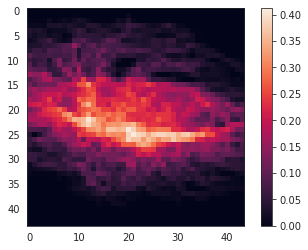

In [15]:
a = plt.imshow(lr[0, 0])
plt.colorbar(a)

In [16]:
with torch.no_grad():
    batch_size = lr.size(0)
    lr = Variable(lr)
    if torch.cuda.is_available():
        lr = lr.cuda()

    learner.netG.eval()
    predict = learner.netG(lr)

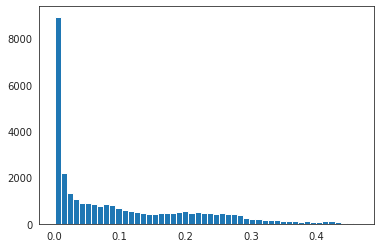

In [17]:
plt.hist(predict.data.cpu().numpy()[0, 0][predict.data.cpu().numpy()[0, 0] != 0], 50);

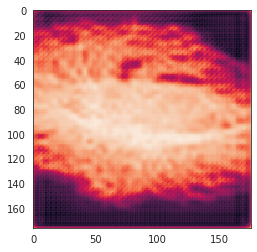

In [18]:
plt.imshow(np.log(predict.data.cpu().numpy()[0, 0]))

# RX

In [9]:
TRAIN_DATA_DIR = '../data/rx/train'
VAL_DATA_DIR = '../data/rx/valid'
PROCESS_DATA_DIR = '../srgan_training'

In [10]:
train_loader, val_loader = get_dataloaders(
        TRAIN_DATA_DIR, VAL_DATA_DIR, dataset_type='rx')

In [11]:
learner = Learner()

# generator parameters: 713481
# discriminator parameters: 5214273


In [12]:
loader, _ = get_dataloaders(
        VAL_DATA_DIR, VAL_DATA_DIR, dataset_type='rx')

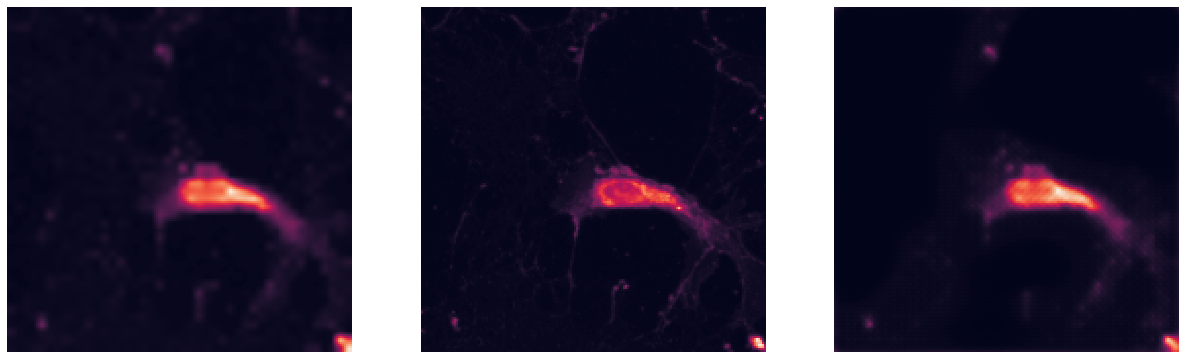

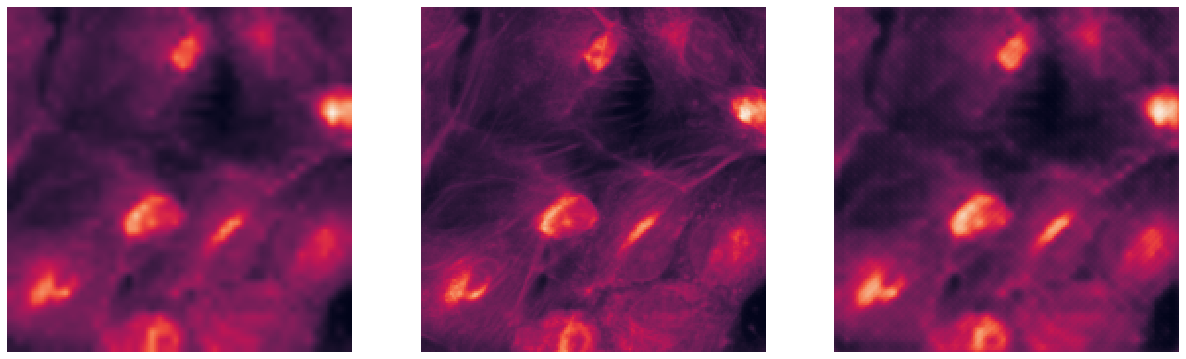

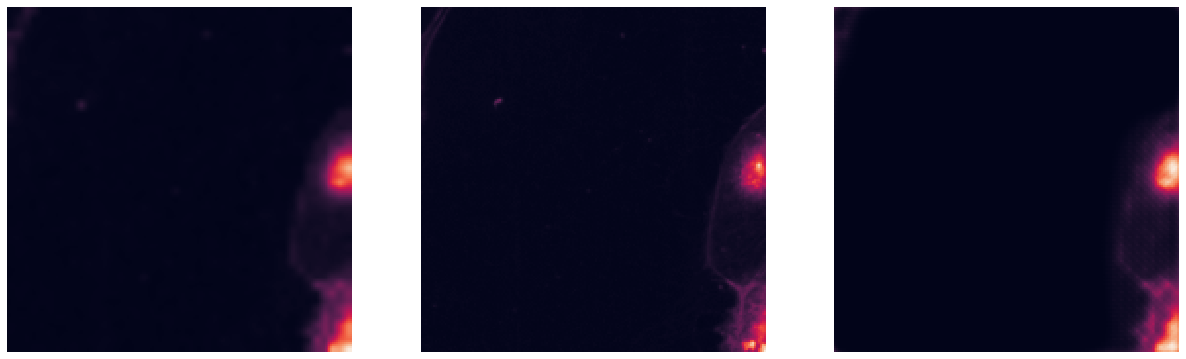

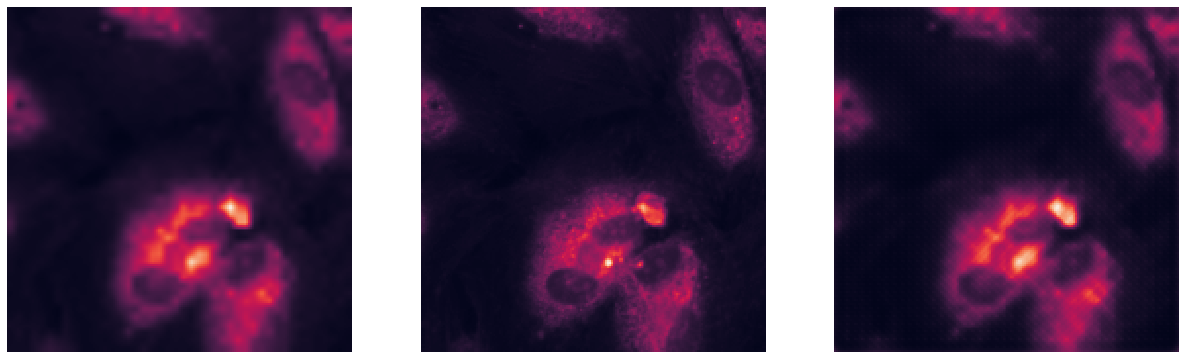

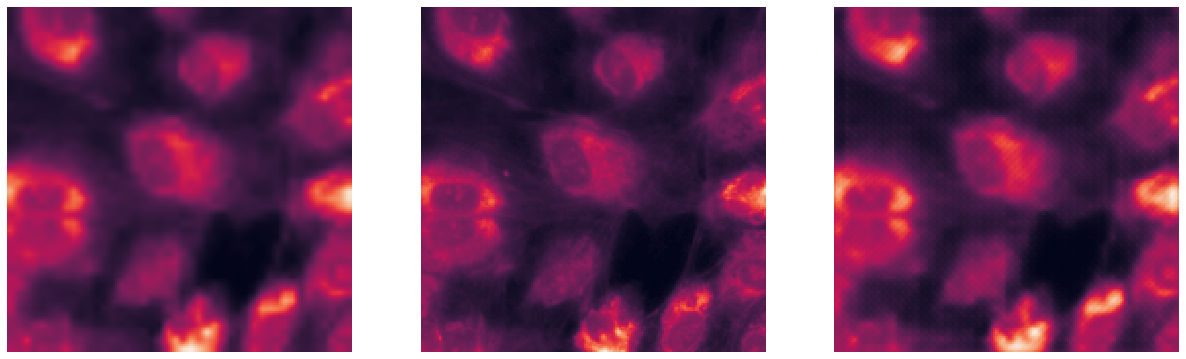

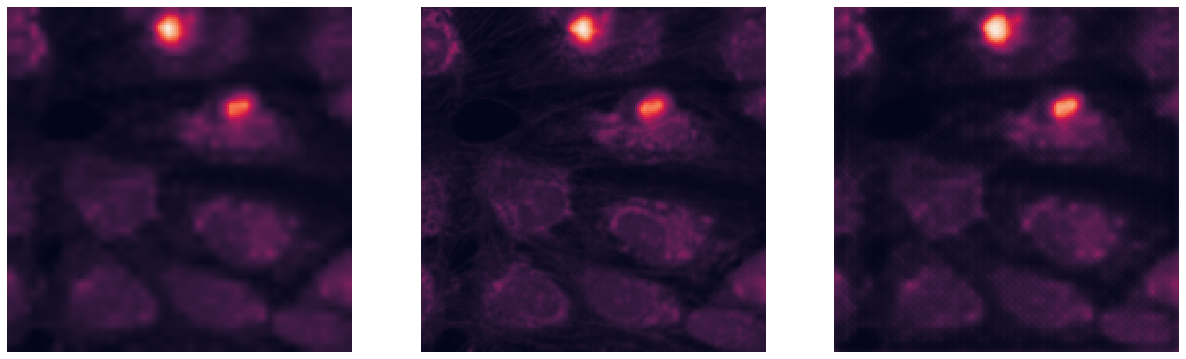

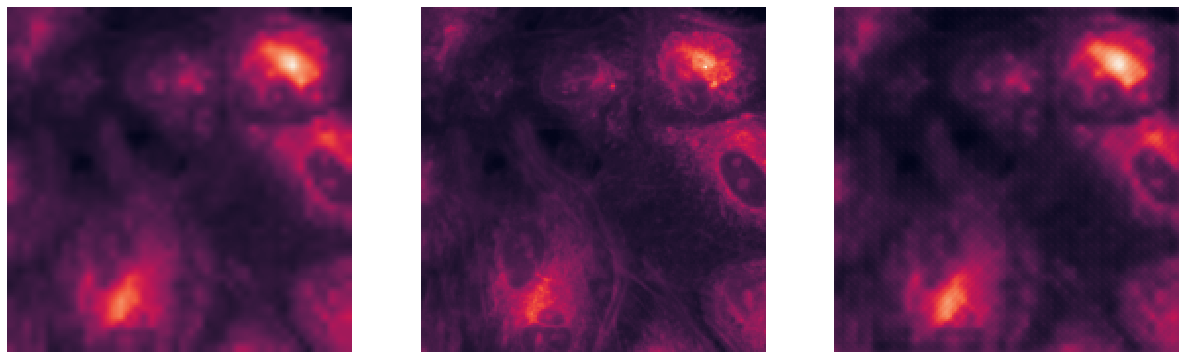

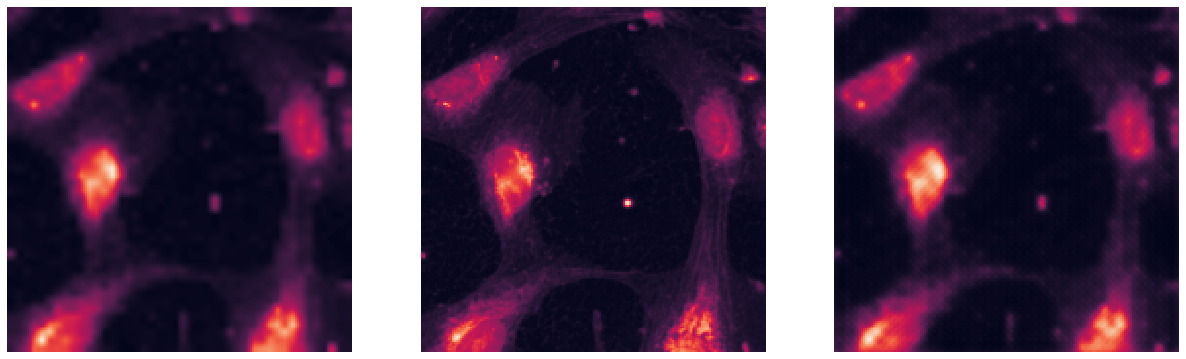

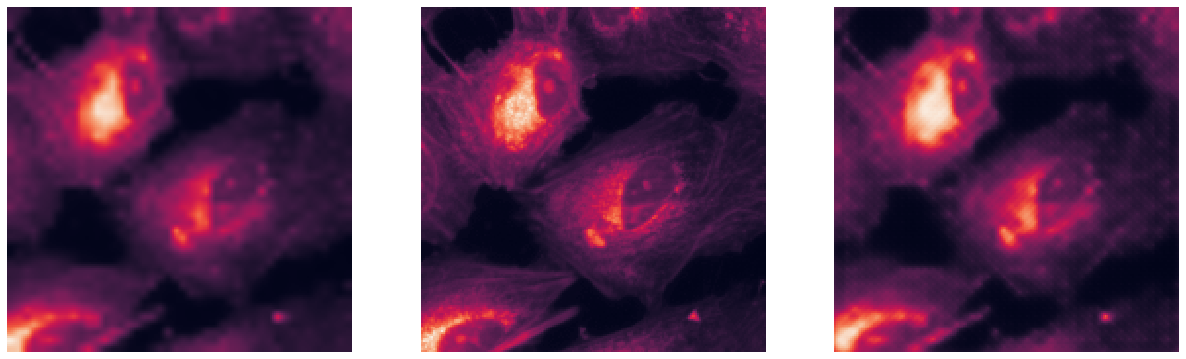

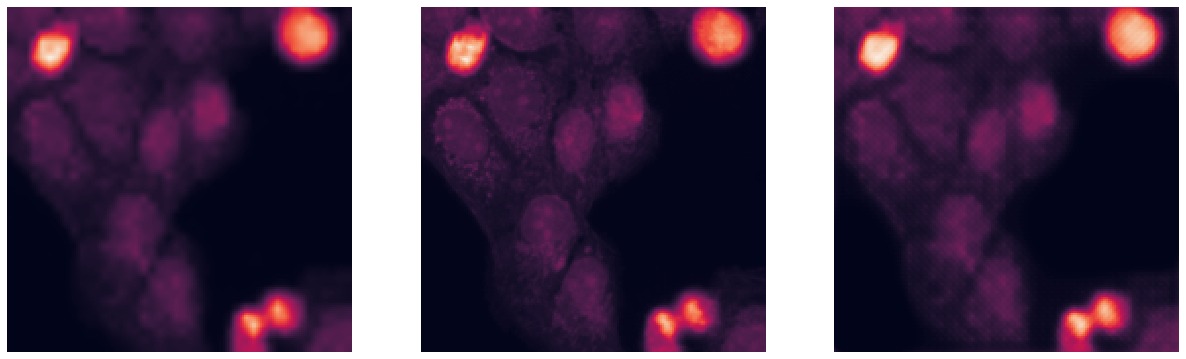

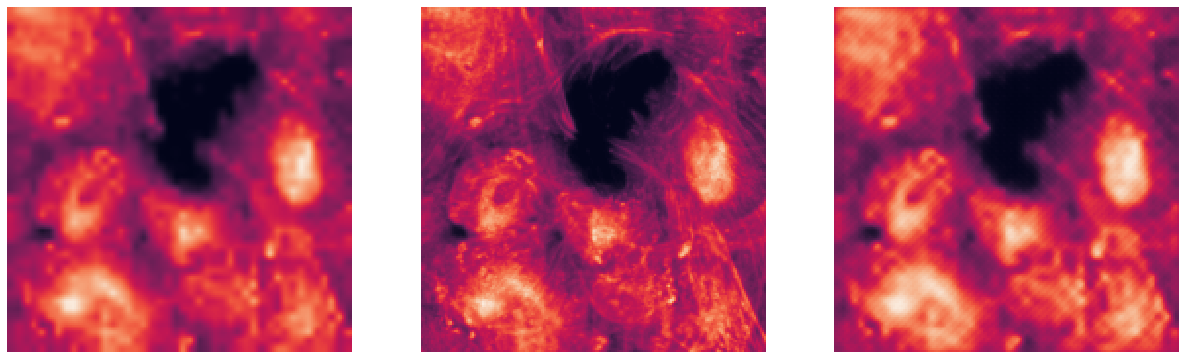

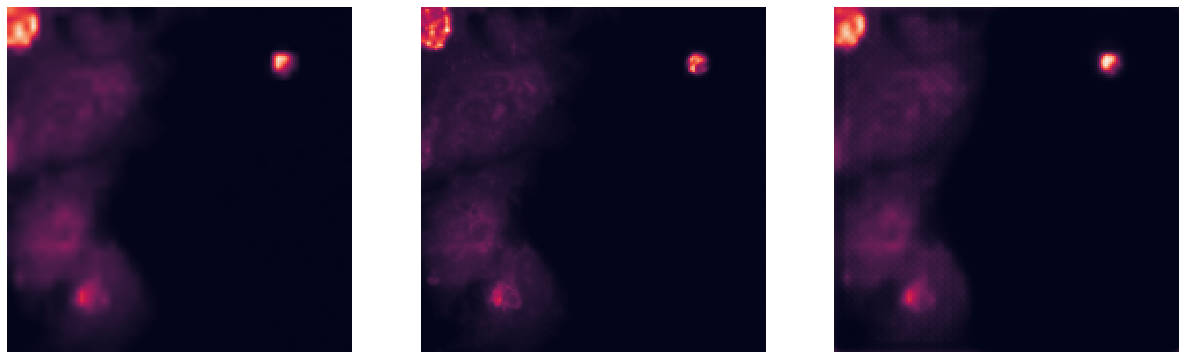

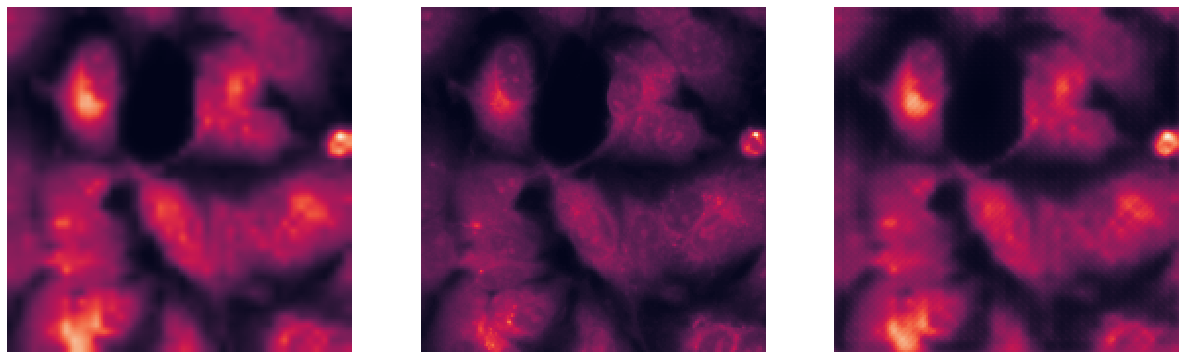

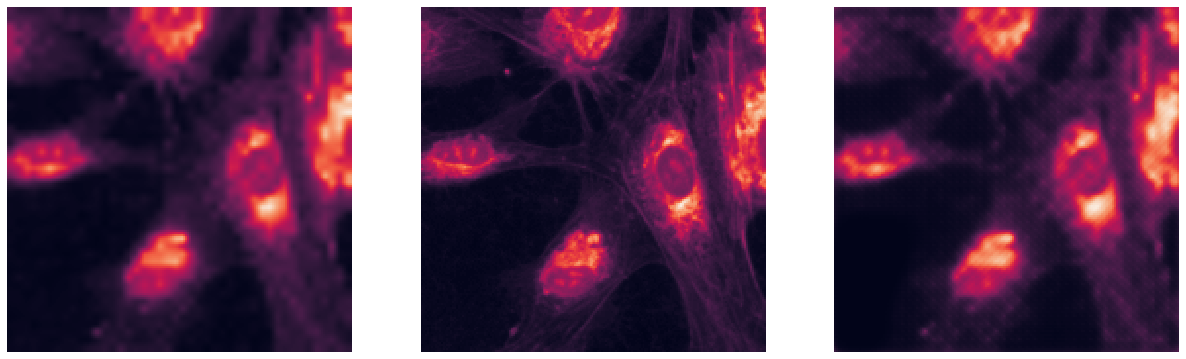

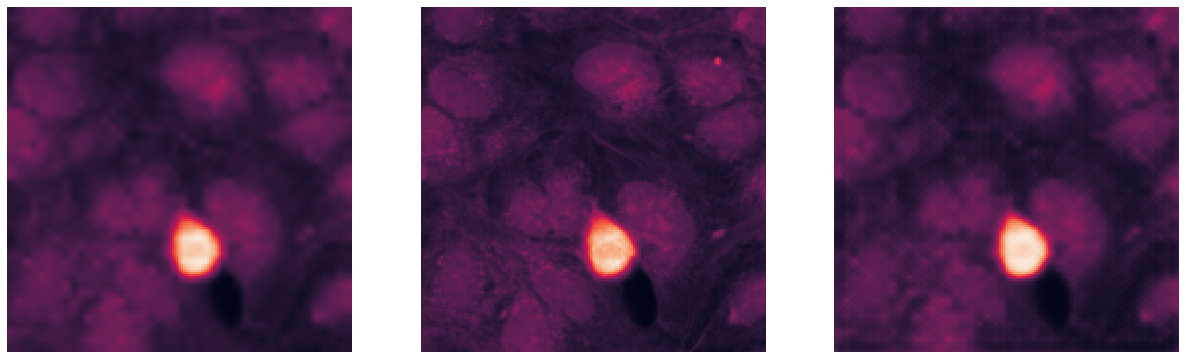

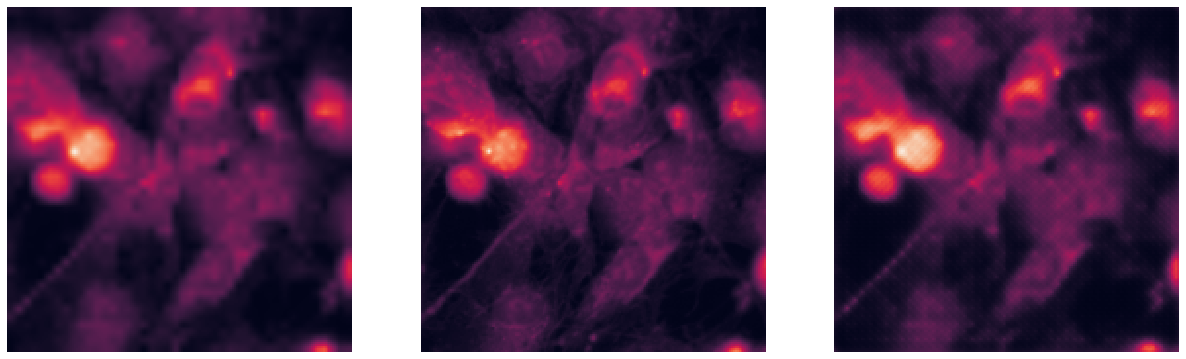

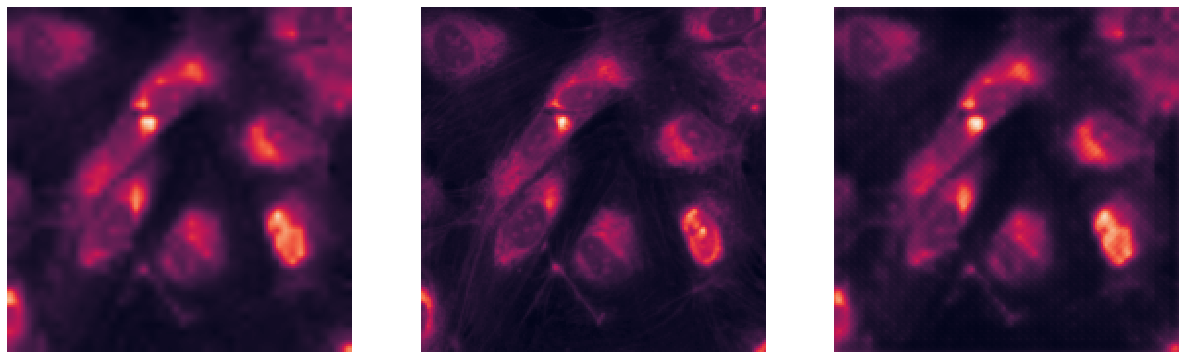

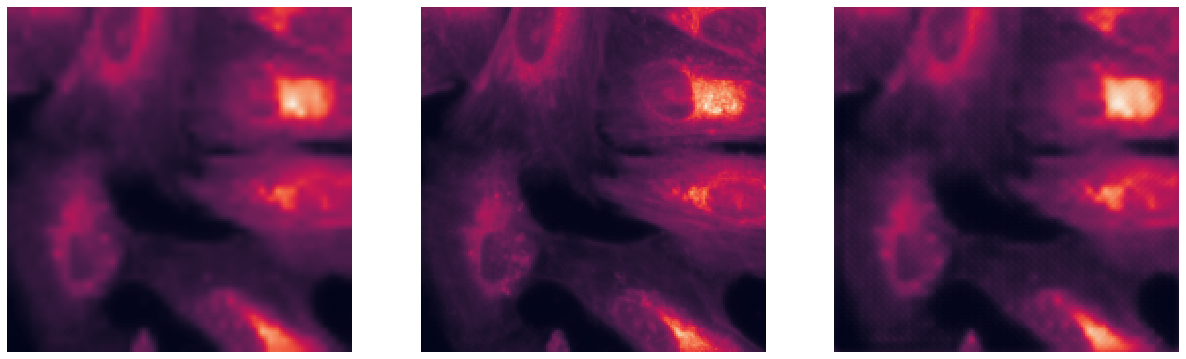

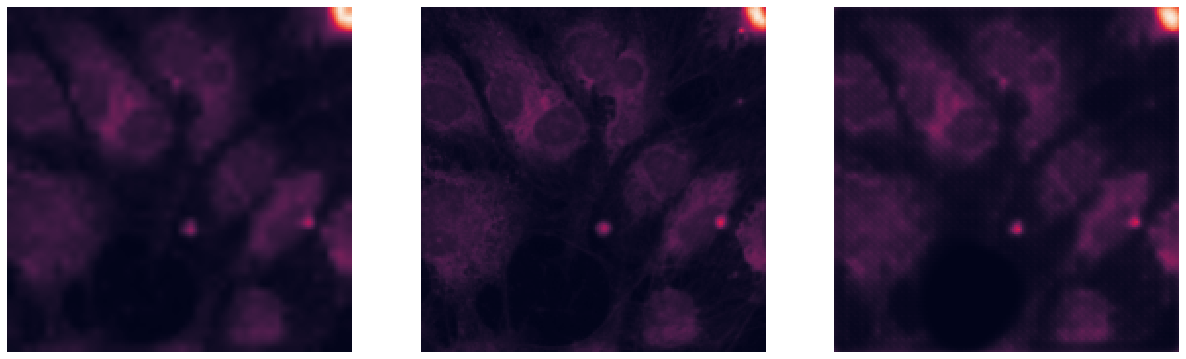

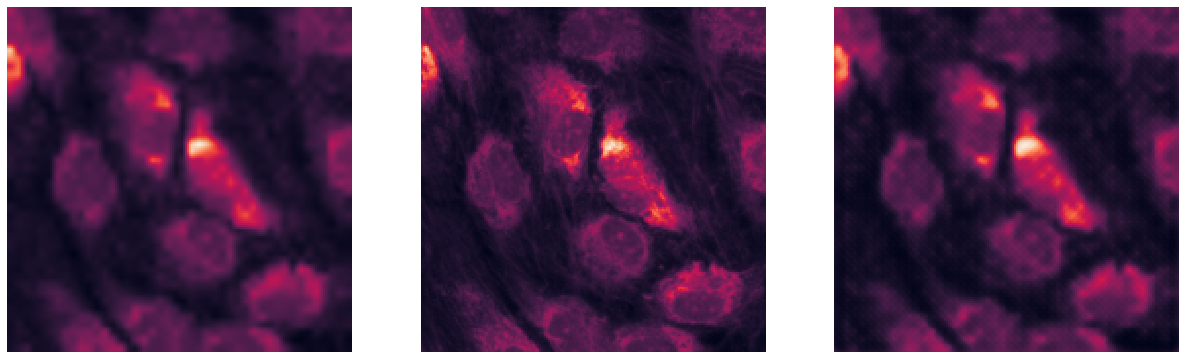

In [17]:
for epoch in range(1, config.PARAMS.NUM_EPOCHS):
    learner.train_on_epoch(train_loader, epoch)
    learner.validate(val_loader, epoch, PROCESS_DATA_DIR)
    
    for lr, hr in loader:
        break

    with torch.no_grad():
        batch_size = lr.size(0)
        lr = Variable(lr)
        if torch.cuda.is_available():
            lr = lr.cuda()

        learner.netG.eval()
        predict = learner.netG(lr)

    clear_output(wait=True)
    for i in range(lr.shape[0]):
        visualise(
            lr[i, 0].data.cpu().numpy(), 
            hr[i, 0].data.cpu().numpy(), 
            predict[i, 0].data.cpu().numpy())

[1/100] Loss_D: 0.9976 Loss_G: 0.0013 D(x): 0.5740 D(G(z)): 0.5716: 100%|██████████| 3635/3635 [39:19<00:00,  1.54it/s]
[converting LR images to SR images] PSNR: 35.4609 dB SSIM: 0.9174: 100%|██████████| 330/330 [00:17<00:00, 30.61it/s]
[saving training results]: 100%|██████████| 66/66 [00:26<00:00,  2.52it/s]


NameError: name 'results' is not defined

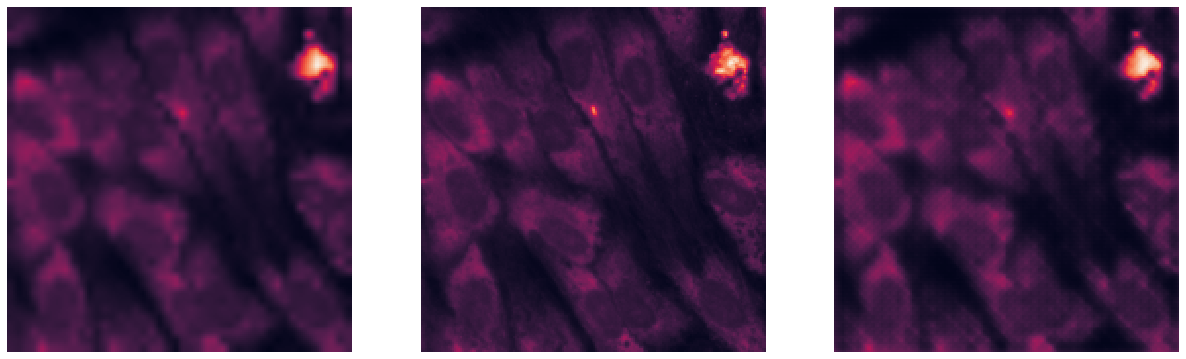

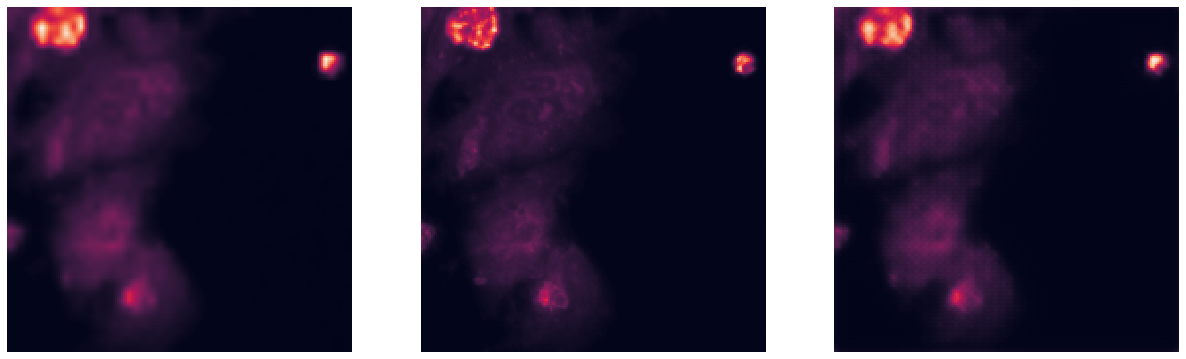

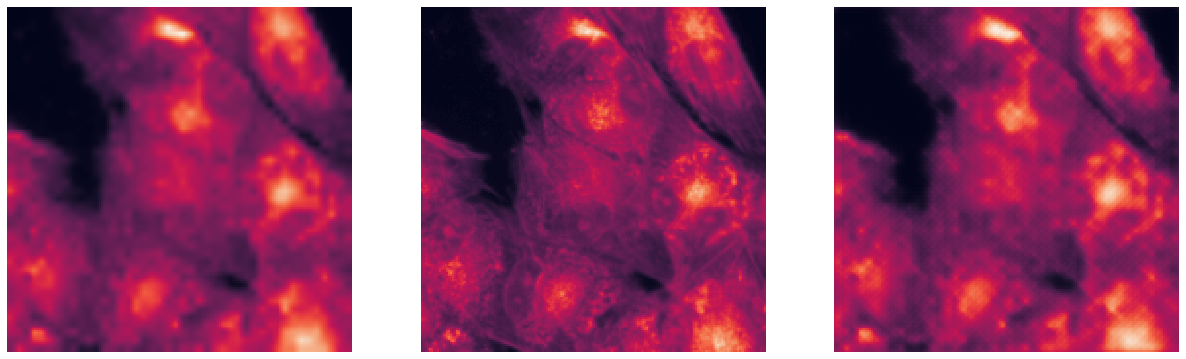

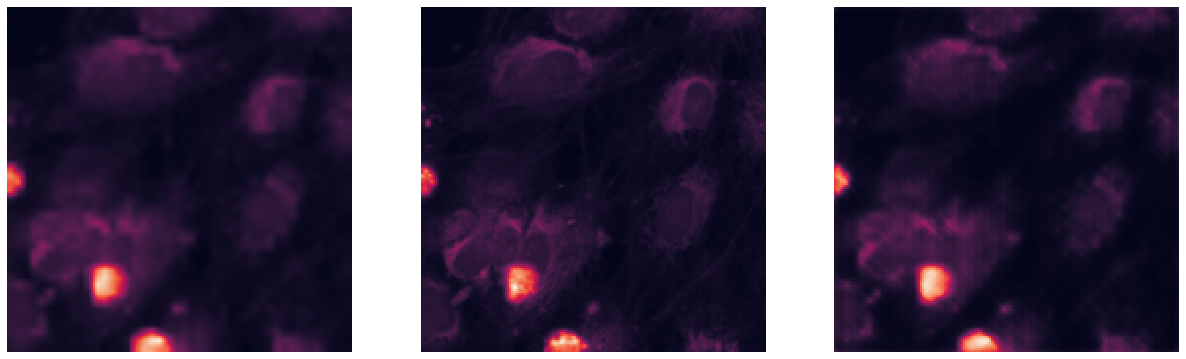

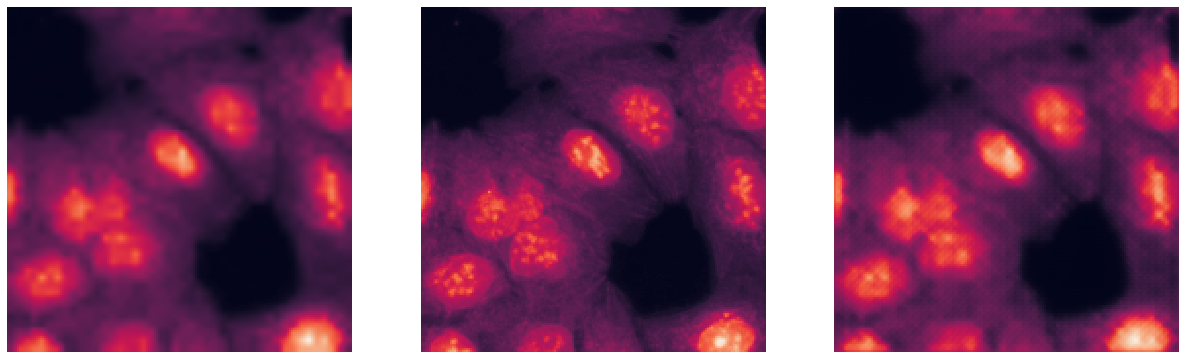

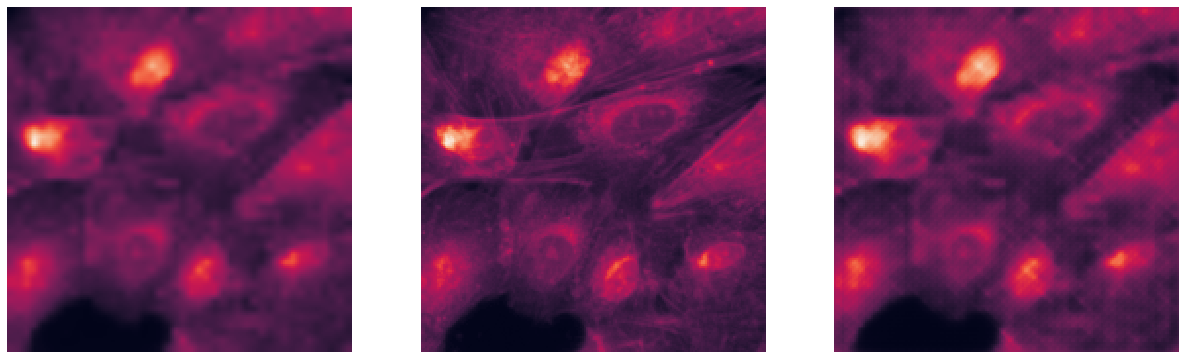

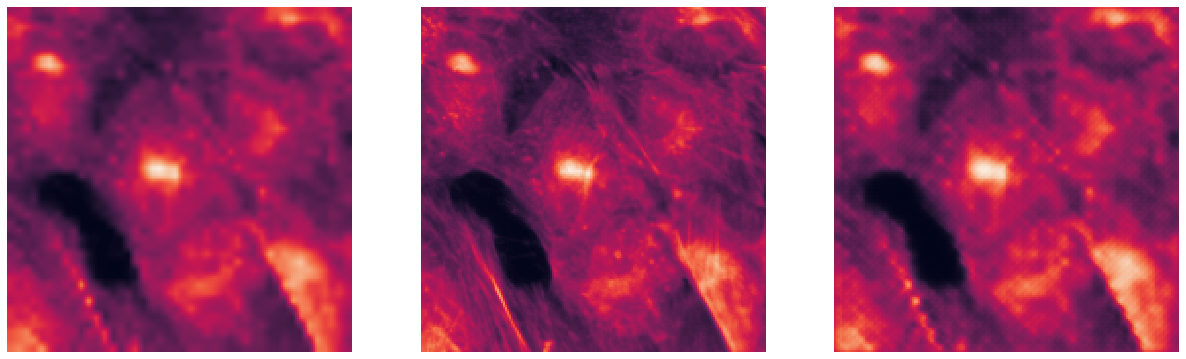

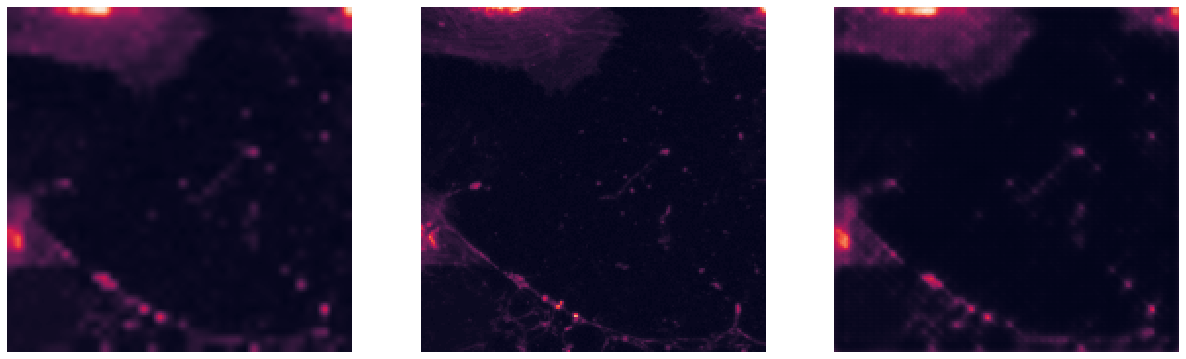

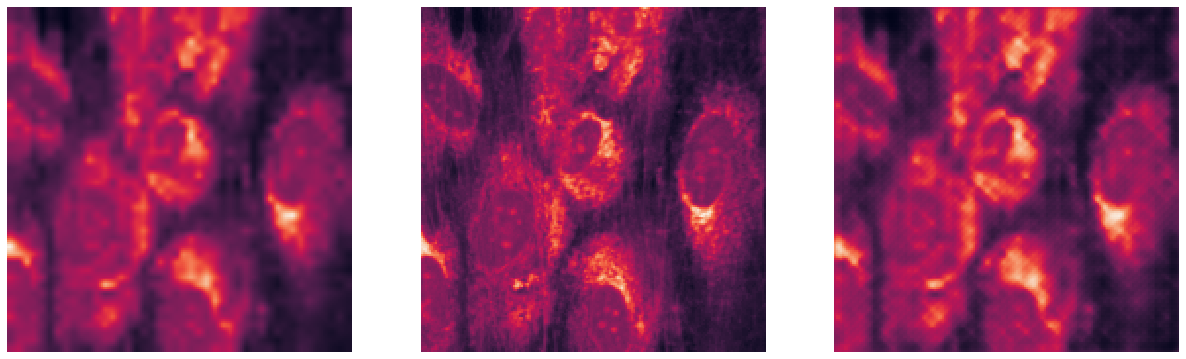

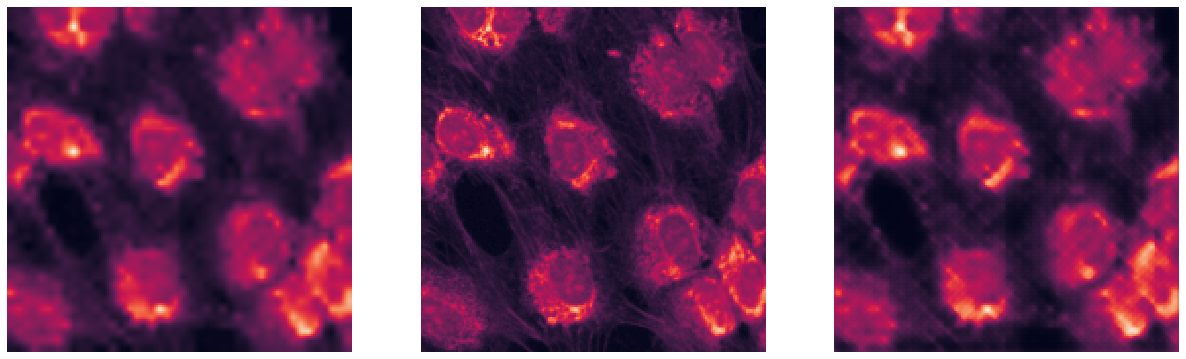

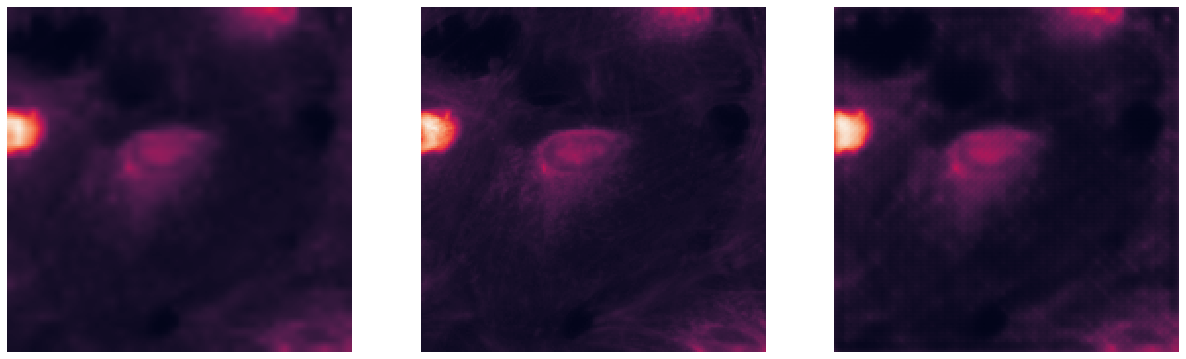

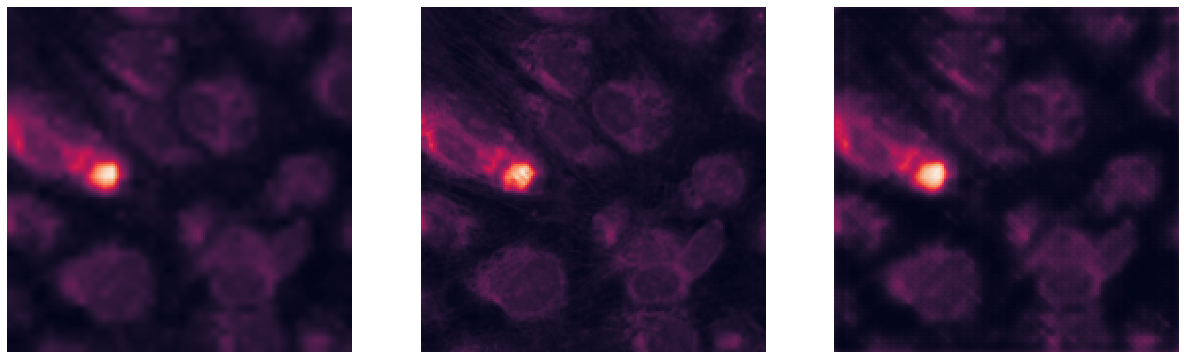

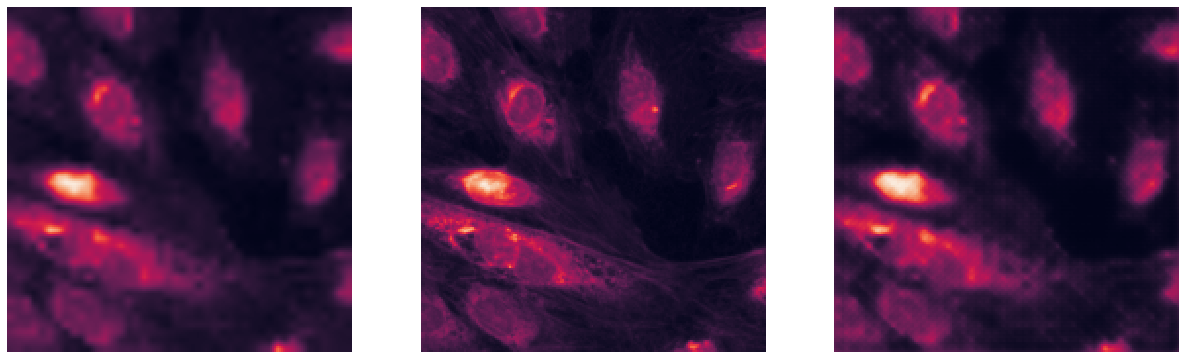

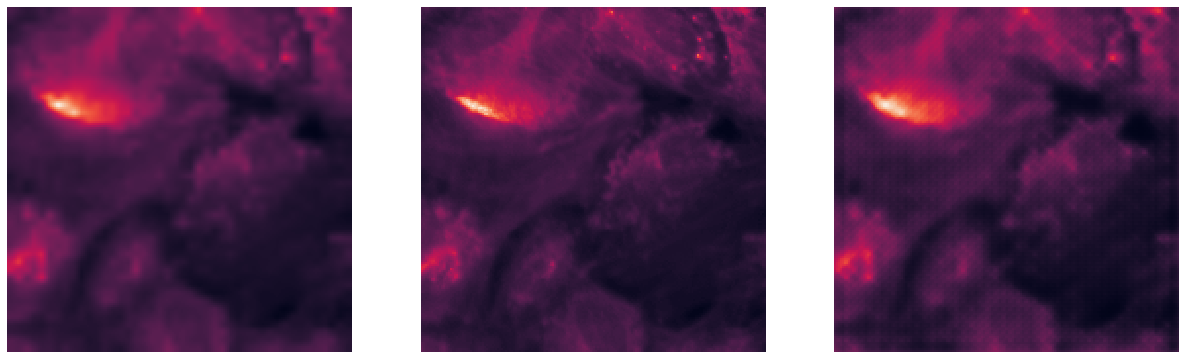

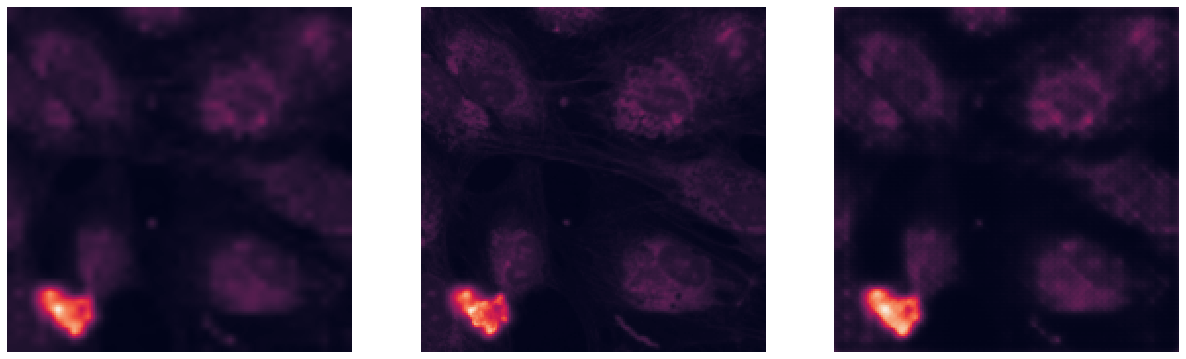

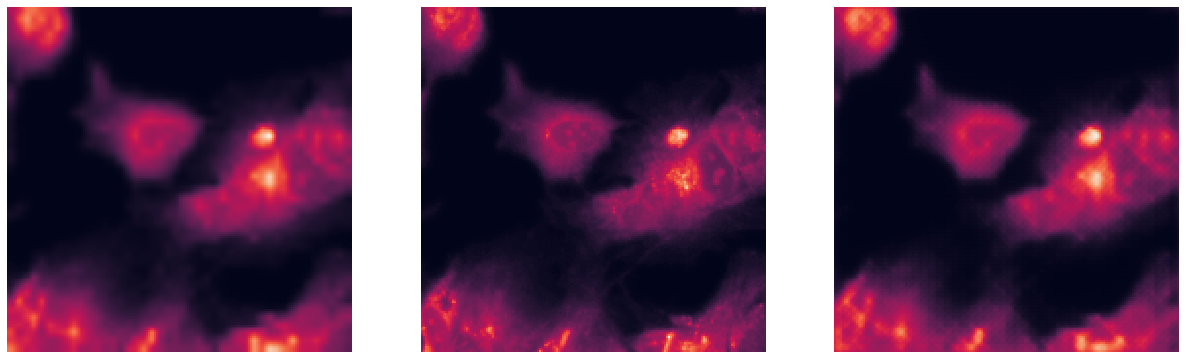

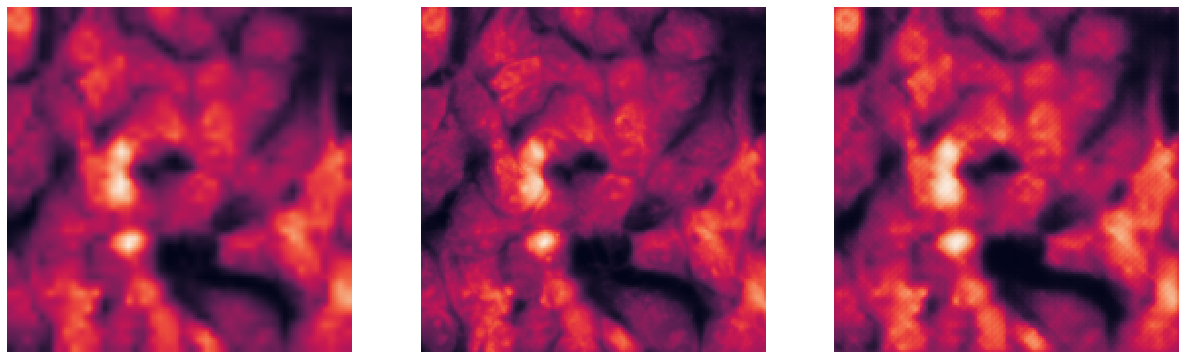

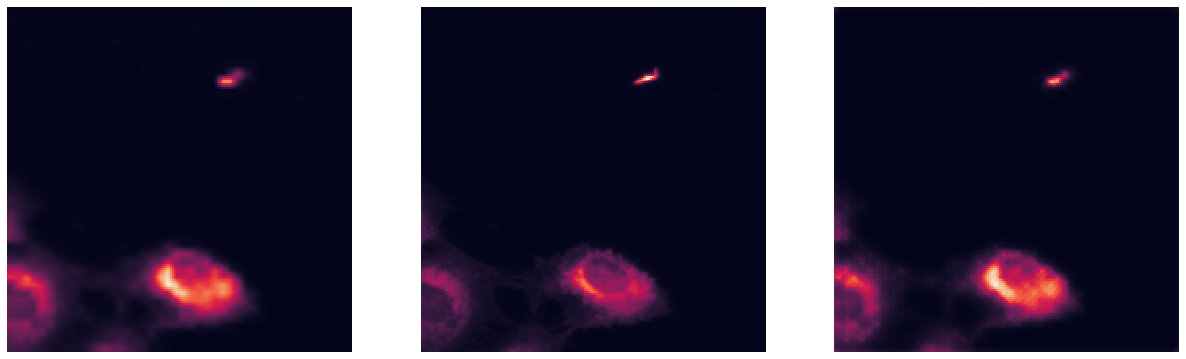

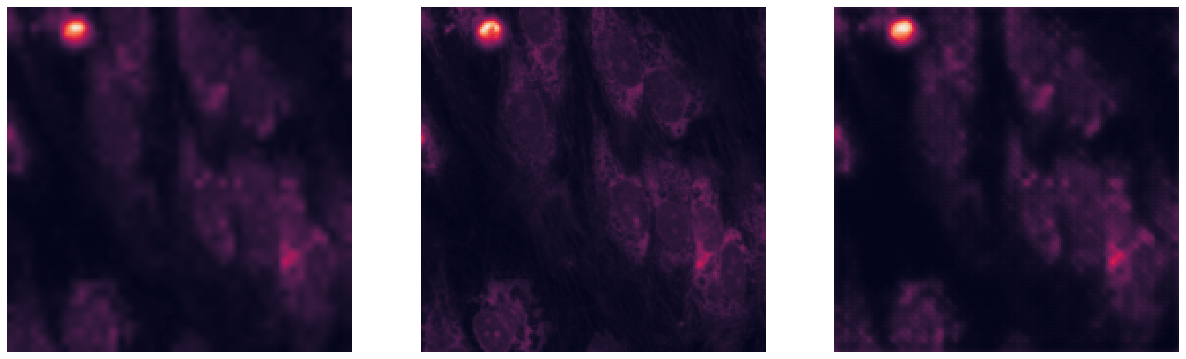

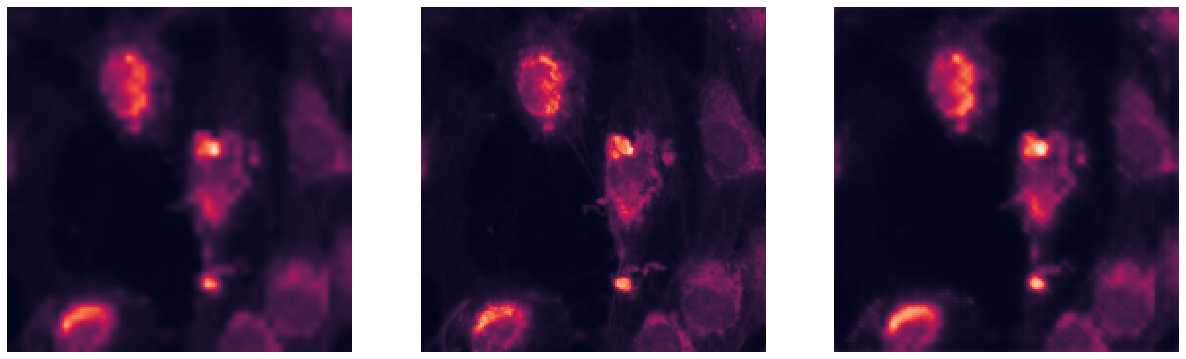

In [14]:
for lr, hr in loader:
    break

with torch.no_grad():
    batch_size = lr.size(0)
    lr = Variable(lr)
    if torch.cuda.is_available():
        lr = lr.cuda()

    learner.netG.eval()
    predict = learner.netG(lr)

clear_output(wait=True)
for i in range(lr.shape[0]):
    visualise(
        lr[i, 0].data.cpu().numpy(), 
        hr[i, 0].data.cpu().numpy(), 
        predict[i, 0].data.cpu().numpy())

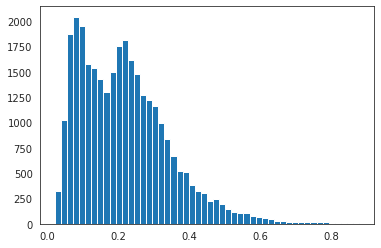

In [19]:
plt.hist(predict.data.cpu().numpy()[0, 0][predict.data.cpu().numpy()[0, 0] != 0], 50);

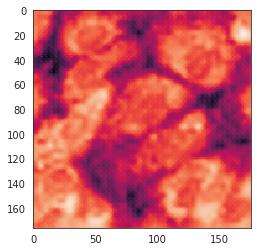

In [20]:
plt.imshow(np.log(predict.data.cpu().numpy()[0, 0]))

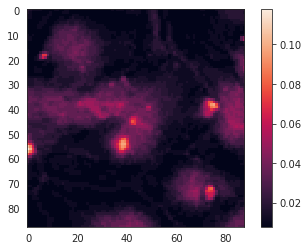

In [11]:
a = plt.imshow(data[0][0, 0])
plt.colorbar(a)

In [5]:
train_SRGAN(TRAIN_DATA_DIR, VAL_DATA_DIR, PROCESS_DATA_DIR, num_epochs=4, perception_enabled=False)

# generator parameters: 713481
# discriminator parameters: 5214273


/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [5]:
train_SRGAN(TRAIN_DATA_DIR, VAL_DATA_DIR, PROCESS_DATA_DIR,
            dataset_type='hpa', upscale_factor=2, num_epochs=6, perception_enabled=False)

# generator parameters: 565768
# discriminator parameters: 5214273


/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/serokell/anaconda3/envs/melscience/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

#### 